## Tensorflow Probability - Distribution Methods & log_prob()  
### Day 3/100 Days of TensorFlow Probability  

Today I am going to look at some of the methods that distributions have. In particular, I am going to focus on the `log_prob()` method, which will become central components of the loss functions defined for optimisation during learning. Here though, we will just explore the use of this method.

This notebook will follow along similar to the previous two. We'll take it slow and look at a univariate example, then extend this to a multivariate example and finish up with a simple univariate outlier experiment.

In [0]:
import collections
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

### log_prob(), the workhorse for optimisation  

The [TensorFlow Distributions white paper](https://arxiv.org/abs/1711.10604) states that at a minimum, all distributions implement the `sample()` and the `log_prob()` methods. There are other methods such as `mean()`, `prob()`, `cdf()`, `variance()`, `entropy()`. Each of these are quite self-explanatory, so we won't labour them.

However, the `log_prob()` method is a little more interesting, mostly because this is the function that we will use later on in this 100-Day-journey to define the loss functions for optimisation during learning.  

Although this is waaaay more advanced that I can handle right now, here is a little teaser, an example of a function which computes the join posterior probability distribution which estimates the failure rate of the Challenger Space Shuttle's O-rings, based on the temperature. Note, this isn't mine, I have blatantly thieved it from [TensorFlow's Introduction to Probabilistic Programming](https://medium.com/tensorflow/an-introduction-to-probabilistic-programming-now-available-in-tensorflow-probability-6dcc003ca29e).

In [0]:
def challenger_joint_log_prob(D, temperature_, alpha, beta):
    """
    Joint log probability optimization function.
        
    Args:
      D: The Data from the challenger disaster representing presence or 
         absence of defect
      temperature_: The Data from the challenger disaster, specifically the temperature on 
         the days of the observation of the presence or absence of a defect
      alpha: one of the inputs of the HMC
      beta: one of the inputs of the HMC
    Returns: 
      Joint log probability optimization function.
    """
    rv_alpha = tfd.Normal(loc=0., scale=1000.)
    rv_beta = tfd.Normal(loc=0., scale=1000.)
    logistic_p = 1.0/(1. + tf.exp(beta * tf.to_float(temperature_) + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
  
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(D))
    )

What I wanted to illustrate here, was the use of the `log_prob()` methods in the return statement of this function. This function was used to estimate the failure of O-rings, given temperature with the objective being to maximise the log probability (i.e. as the learner iterates, it incrementally adjusts the parameter estimates, following the gradient of the log probability).

To be really, really (painfully) clear: the `log_prob()` method is defined for a given distribution and it takes an observations as a parameter. Thus, we are asking the question: "how likely is it that this observation would be observed given this distributions"?

It took me a couple of days to understand that this! At first, the return statement looked like an alien language to me. Once I realised that this is what the `log_prob()` function does a lightbulb went off and I immediately *got it*. Perhaps I should have immediately grasped this... but I didn't. *shrug*  

### A univariate example  

Let's illustrate this. A couple of days ago I had miy lightbulb moment, but it really cemented it once I had plotted a few examples. For this example, let's use something we haven't seen yet, the Chi2 distributions. Note, that all of the distributions are [documented here](https://www.tensorflow.org/probability/api_docs/python/tfp).

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


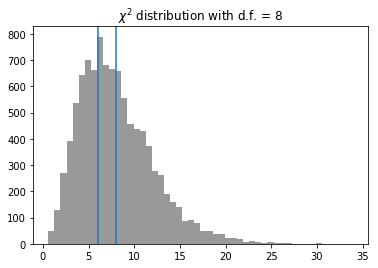

In [25]:
rv_chi2 = tfd.Chi2(df = 8)

plt.hist(rv_chi2.sample(10000), bins=50, color='k', alpha=0.4)
plt.axvline(x = rv_chi2.mode().numpy())
plt.axvline(x = rv_chi2.mean().numpy())
plt.title("$\chi^2$ distribution with d.f. = 8")
plt.show()

Above, you can se what our Chi-squared distribution looks like. Values around 8 are very likely. Values lower than ~2 or higher than 15 are les likely.

The `log_prob()` represents this for us:

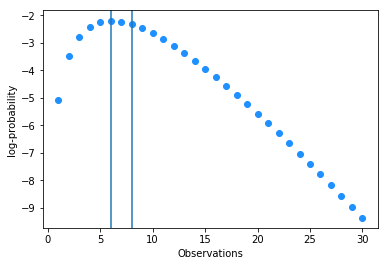

In [26]:
observations = range(0, 31)
log_probability = rv_chi2.log_prob(observations)

plt.scatter(observations, log_probability,
            color = 'dodgerblue')
plt.axvline(x = rv_chi2.mode().numpy())
plt.axvline(x = rv_chi2.mean().numpy())
plt.xlabel("Observations")
plt.ylabel("log-probability")
plt.show()

Notice, that the log-probability is highest around the median/mean of the distribution. It tails off quite quickly either side of the center of the distribution.

Equally, we could transform these and plot the probability:

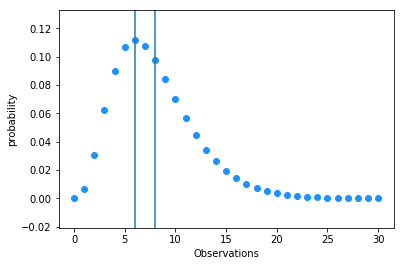

In [27]:
observations = range(0, 31)
probability = np.exp(rv_chi2.log_prob(observations).numpy())

plt.scatter(observations, probability,
            color = 'dodgerblue')
plt.axvline(x = rv_chi2.mode().numpy())
plt.axvline(x = rv_chi2.mean().numpy())
plt.xlabel("Observations")
plt.ylabel("probability")
plt.show()

Again, we get something very similar, where the probability is maximised at the center of the distribution and it tails off quite quickly.

### Multivariate Example  

These principals are exactly the same for a multivariate distribution. We are simply asking the question: "given our distribution, how likely is it that our observations arise from this distribution"? Another way to think about "an observation" is "data" - i.e. "how likely is it that our data arises from this distribution"?

Let's look at a multivariate example. We will assume the following 2-dimensions multinormal:

(70, 2, 2)


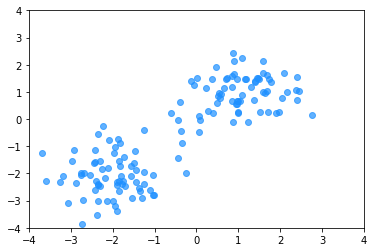

In [99]:
np.random.seed(101)

mvn = tfd.MultivariateNormalDiag(
  loc = [-2.0, 1.0],
  scale_diag = [[0.66, -0.72], [0.81, 0.68]]
)

simulation = mvn.sample(70)
print(simulation.shape)

plt.scatter(simulation.numpy()[:,0], simulation.numpy()[:,1],
            color='dodgerblue', alpha=0.7)
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.show()

This is a 'somewhat interesting' sample of points. There are clearly two clusters here, one centered around (-2, 2) and the other around (1, 1). 

Let's plot the log_probability of each of these points. We'll show this as the colour:

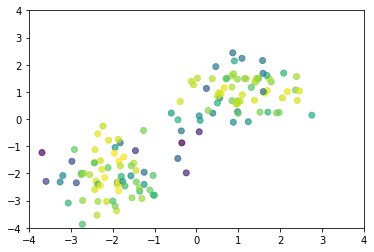

In [100]:
plt.scatter(simulation.numpy()[:,0], simulation.numpy()[:,1],
            c=mvn.log_prob(simulation).numpy(), alpha=0.7)
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.show()

I need to work on my plotting in python. But, we can see a picture emerging here: points near the centers of these two clusters are more likely than those near the edges, hence the darker colours towards the edges.

Let's create a new MVN, with more variance and then compare this to our "base distribution" (the one above). 

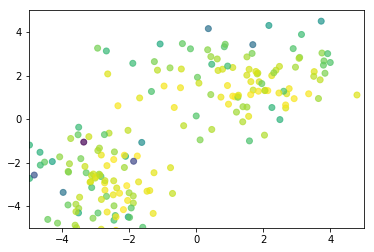

In [114]:
np.random.seed(67)

mvn2 = tfd.MultivariateNormalDiag(
  loc = [-3, 1.8],
  scale_diag = [[0.96, -1.72], [1.31, 1.18]]
)
simulation = mvn2.sample(100)

plt.scatter(simulation.numpy()[:,0], simulation.numpy()[:,1],
            c=mvn.log_prob(simulation).numpy(), alpha=0.7)
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

As we would expect, we see something very similar. Points that are near the center of our "base distribution" have a higher log-probability than those which are further away.

In particular, in the plot above you can see some strong dark colours emerging towards the edges of these clusters.

### Univariate Anomaly Detection  

Finally, let's do something a little more interesting with this. Let's perform a very (*very*) basic univariate anomaly detection. Here, we will define the expected range of our observations using a Chi2 distribution and use this is analyse our "data". We will define two 'anomaly thresholds':

  - anything with a log-probability < -4 will be "unlikely"  
  - anything with a log-probability < -6 will be "very anomalous"

I am simply going to simulate some data for this. I will use our previous $\chi^2$ distribution to sample from, then multiply this by 3 just to give us something interesting.

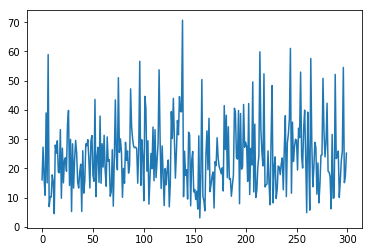

In [120]:
data = rv_chi2.sample(300)
plt.plot(range(0,300), data.numpy()*3)
plt.show()

Again, let me emphasise how *very simple* I am going to make this. Let's assume that we don't know that these data are sampled from a $\chi^2$ distribution. Instead, let's assume that our data-generating process is approximately normal with a mean of 20 and a standard deviation of 10 (these seem somewhat reasonable, just looking at the data above).

So, step one: let's define our distribution for "normal activity", which we will call the baseline:

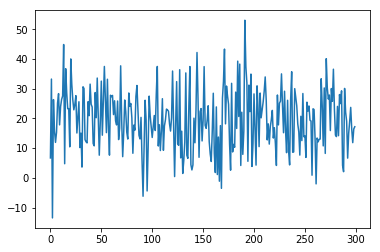

In [122]:
baseline = tfd.Normal(loc = 20, scale = 10)
plt.plot(range(0, 300), baseline.sample(300).numpy())
plt.show()

Happily, our "range of normal activity" is pretty much inline with our observed data. However, our observed data has a bit more positive skew and these higher points should be "anomalous".

Let's find out...

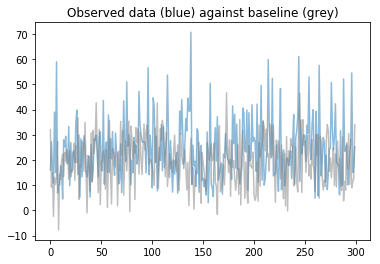

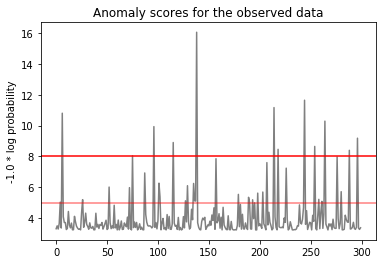

In [134]:
anomaly_scores = -1.0 * baseline.log_prob(data.numpy()*3)

plt.plot(range(0,300), data.numpy()*3, alpha=0.5)
plt.plot(range(0, 300), baseline.sample(300).numpy(), color='grey', alpha = 0.5)
plt.title("Observed data (blue) against baseline (grey)")
plt.show()

plt.plot(range(0, 300), anomaly_scores, color='grey')
plt.axhline(y = 5, color='red', alpha=0.5)
plt.axhline(y = 8, color='red')
plt.ylabel("-1.0 * log probability")
plt.title("Anomaly scores for the observed data")
plt.show()

Nice! This is a super simple approach, but it's an approach I would be happy to use (perhaps with a better baseline distribution or, allowing for a little more skew). But overall, this is really positive.

We can see in the top plot, that our assumed baseline is perfectly reasonable. And form the second plot, and even with these simple assumptions, there are only ~10 observations which are "very anomalous".

There ends Day 03.